unzip -o happy_v2.zip -d ~/code/reasearch/tensorflow_research/data/happy;
unzip -o happy_v2.zip  -d ~/code/reasearch/tensorflow_research/data/happy;
unzip -o sad_v2.zip -d ~/code/reasearch/tensorflow_research/data/sad;
unzip -o sad_v2.zip  -d ~/code/reasearch/tensorflow_research/data/sad;


unzip -o happy.zip -d ~/code/reasearch/tensorflow_research/data/happy;
unzip -o happy.zip  -d ~/code/reasearch/tensorflow_research/data/happy;
unzip -o sad.zip -d ~/code/reasearch/tensorflow_research/data/sad;
unzip -o sad.zip  -d ~/code/reasearch/tensorflow_research/data/sad;


In [608]:
import os
import tensorflow as tf
import cv2
import imghdr # DeprecationWarning: 
from PIL import Image
from matplotlib import pyplot as plt
from typing import List, Tuple, Dict, Any, Union

In [609]:
DATA_DIR = 'data'
IMAGE_EXTENSIONS = ["JPEG", "PNG", "GIF", "BMP"]
LOG_DIR = 'logs'

In [610]:
def sanitize_images(files: List[str]) -> None:
    
    deleted_files = 0  # counter for deleted files
    
    for filename in os.listdir(files):
        file_path = os.path.join(files, filename)

        try:
            with Image.open(file_path) as img:
                if img.format not in IMAGE_EXTENSIONS:
                    print(f'Deleting (not a valid format) --> {filename}')
                    os.remove(file_path)
                    deleted_files += 1
                    continue
                print(filename, img.format, "%dx%d" % img.size, img.mode)
        except IOError:
            print(f'Deleting --> {filename}')
            os.remove(file_path)
            deleted_files += 1  # increment the counter
            continue
        
        
        try:
            x = cv2.imread(file_path)
            if x is None:
                print(f'Deleting: cannot be read by CV2 - {filename}')
                os.remove(file_path)
                continue
        except Exception as e:
            print(f'Deleting: cannot be read by CV2 - {filename}')
            os.remove(file_path)
            continue
        

        try:
            # Get file size in KB
            file_size = os.path.getsize(file_path) / 1024  # in KB
            if file_size < 10:
                print(f'Deleting (less than 10KB) --> {filename}')
                os.remove(file_path)
                deleted_files += 1  # increment the counter
                continue
        except Exception as e:
            print(f'Deleting: cannot get file size - {filename}')
            os.remove(file_path)
            continue
            
    print(f'Total deleted files: {deleted_files}')


In [611]:
# Loop through the `data` directory and clean up data
for directory in os.listdir(DATA_DIR):
    print(f'--> Cleaning up {directory} directory <--')
    directory: List[str] = os.path.join(DATA_DIR, directory)
    sanitize_images(directory)
    print(f'--> Done cleaning up {directory} directory <--')


--> Cleaning up happy directory <--
happy-diverse-people-celebrating-diversity-real-group-isolated-white-cheering-33262674.jpg JPEG 800x383 RGB
SHPL_S1_FG_101_00002306_Still001_3000-2-1.jpg JPEG 3000x1688 RGB
ng-sun-carefree-happiness-vacation-sea-multicultural-multinational-181383849.jpg JPEG 1600x1157 RGB
happy-people-welcome-sign-vector-6364439.jpg JPEG 1000x1080 RGB
05-12-21-happy-people.jpg JPEG 1400x880 RGB
happy.jpg JPEG 722x516 RGB
py-company-team-colleagues-jumping-flat-winning-characters-collection-vector.jpg JPEG 599x200 RGB
170404-happy-workers-feature.jpg JPEG 2000x1333 RGB
image18.jpeg JPEG 300x168 RGB
MV5BMTM3ODM0NTQ1MF5BMl5BanBnXkFtZTcwMzAxMTM5OA._V1_.jpg JPEG 1433x2048 RGB
friends-happy-190821.jpg JPEG 1600x900 RGB
30470889.jpg JPEG 226x339 RGB
images19.jpg JPEG 177x285 RGB
pexels-photo-1999504.jpeg JPEG 4000x6000 RGB
goup-happy-people-group-jumping-isolated-white-background-35582232.jpg JPEG 800x560 RGB
jumping-444612_1280.jpg JPEG 1280x853 RGB
portrait-smiling-young-

In [612]:
# Avoid OOM error by setting GPU Memory Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [613]:
data = tf.keras.utils.image_dataset_from_directory('data')
data_iter = data.as_numpy_iterator()
batch = data_iter.next()

Found 250 files belonging to 2 classes.


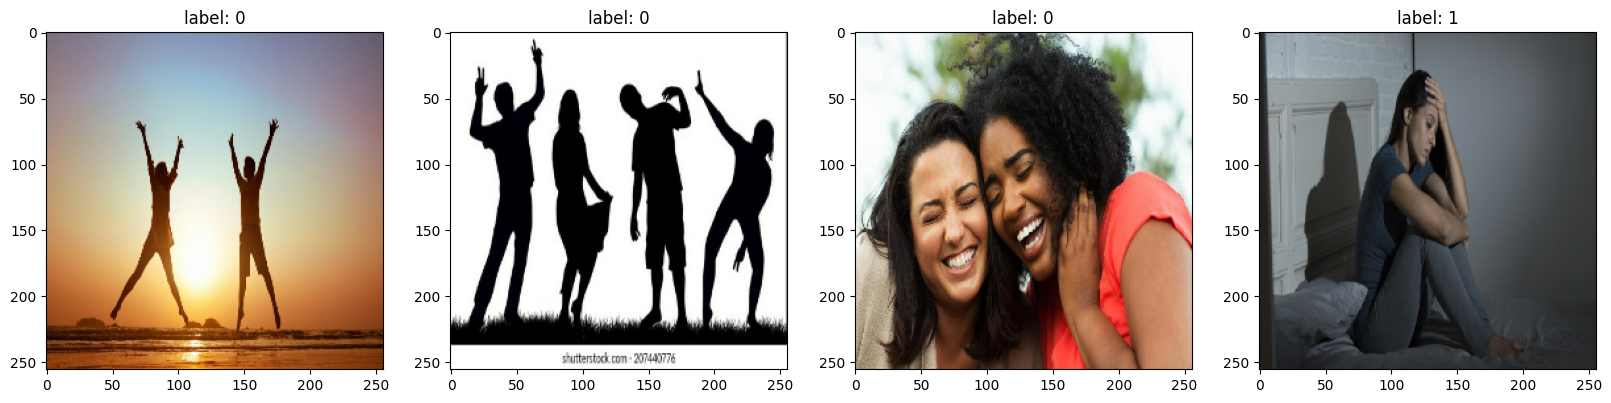

In [614]:
# Sample batch images
fig, ax = plt.subplots(ncols=4,figsize=(20, 20))
for i, img in enumerate(batch[0][:4]):
    ax[i].imshow(img.astype(np.uint8))
    ax[i].title.set_text(f'label: {batch[1][i]}')

In [615]:
scaled_data = data.map(lambda x, y: (x / 255.0, y))
# data = data.map(lambda x, y: (tf.image.resize(x, (224, 224)), y))
# data = data.map(lambda x, y: (tf.keras.applications.mobilenet_v2.preprocess_input(x), y))
# data = data.map(lambda x, y: (tf.keras.applications.resnet50.preprocess_input(x), y))
scaled_iterator = scaled_data.as_numpy_iterator()
scaled_batch = scaled_iterator.next()

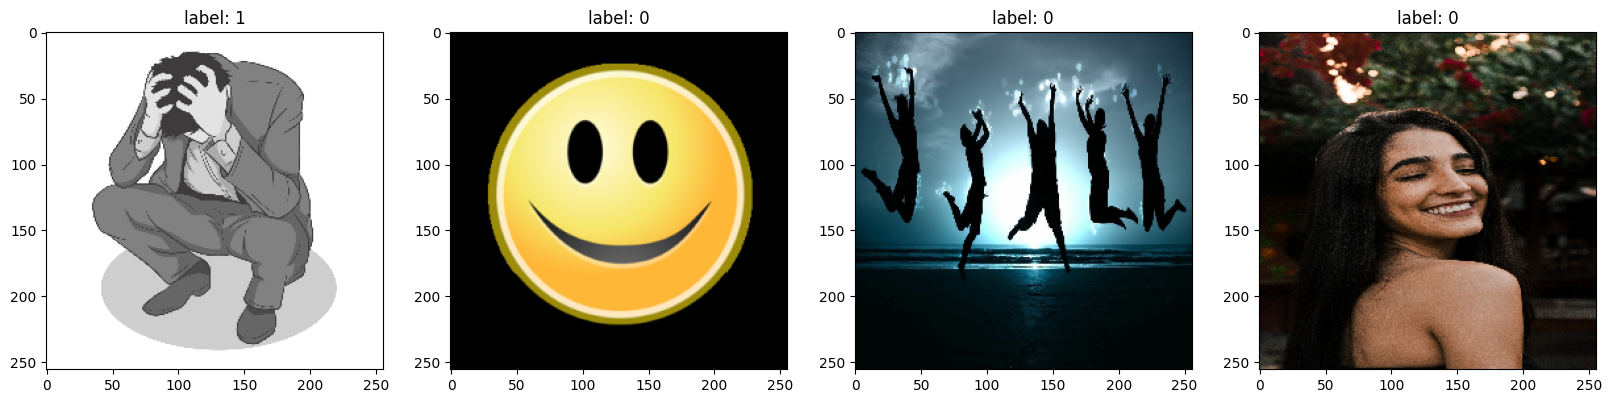

In [616]:
fig, ax = plt.subplots(ncols=4,figsize=(20, 20))
for i, img in enumerate(scaled_batch[0][:4]):
    ax[i].imshow(img)
    ax[i].title.set_text(f'label: {scaled_batch[1][i]}')


In [617]:
len(scaled_batch)

2

In [618]:
train_size = int(len(scaled_batch)*0.7)+1
val_size = int(len(scaled_batch)*0.2 )+1
test_size= int( len(scaled_batch)*0.1)+1
print(train_size, val_size, test_size)

2 1 1


In [619]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [620]:
len(test)

1

### 3. Deep Model

3.1 Build Deep Learning Model

In [621]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D

In [622]:
model = Sequential()
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D(2))

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [623]:
model.compile(optimizer='adam', loss=tf.losses.BinaryFocalCrossentropy(), metrics=['accuracy'])

In [624]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 127, 127, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_18 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 62, 62, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 30, 30, 16)       

In [625]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=LOG_DIR, histogram_freq=1)

In [626]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20


2023-06-28 15:55:15.499770: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/2 [==============>...............] - ETA: 1s - loss: 7.0793 - accuracy: 0.5312

2023-06-28 15:55:17.335672: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 4s 2s/step - loss: 174.9193 - accuracy: 0.5312 - val_loss: 144.9331 - val_accuracy: 0.6250
Epoch 2/20
2/2 [==============================] - 3s 2s/step - loss: 133.5742 - accuracy: 0.5156 - val_loss: 31.3935 - val_accuracy: 0.5938
Epoch 3/20
2/2 [==============================] - 3s 2s/step - loss: 17.8966 - accuracy: 0.6406 - val_loss: 22.3542 - val_accuracy: 0.5000
Epoch 4/20
2/2 [==============================] - 3s 2s/step - loss: 32.4256 - accuracy: 0.4688 - val_loss: 19.5663 - val_accuracy: 0.5625
Epoch 5/20
2/2 [==============================] - 3s 2s/step - loss: 13.3129 - accuracy: 0.5781 - val_loss: 6.6720 - val_accuracy: 0.5000
Epoch 6/20
2/2 [==============================] - 3s 2s/step - loss: 5.9029 - accuracy: 0.5156 - val_loss: 1.3393 - val_accuracy: 0.7188
Epoch 7/20
2/2 [==============================] - 3s 2s/step - loss: 2.6684 - accuracy: 0.6250 - val_loss: 1.4807 - val_accuracy: 0.6562
Epoch 8/20
2/2 [========================

3.3 Plot Performance

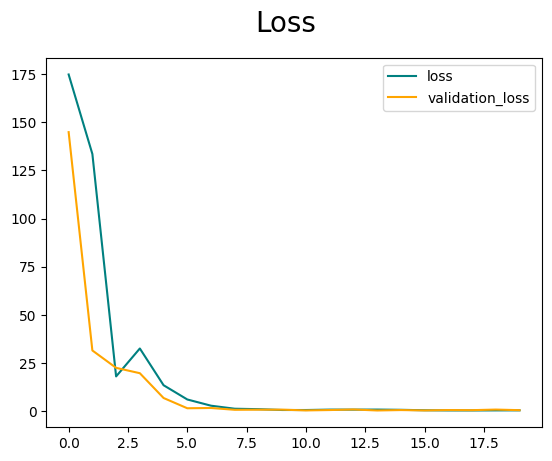

In [627]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='validation_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper right')
plt.show()

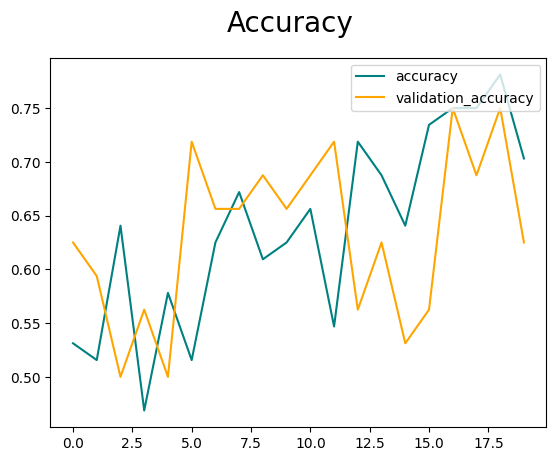

In [628]:
fig = plt.figure( )
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='validation_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper right')
plt.show()

In [629]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [630]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [665]:
for batch in test.as_numpy_iterator():
    x, y = batch
    y_pred = model.predict(x)
    pre.update_state(y, y_pred)
    re.update_state(y, y_pred)
    acc.update_state(y, y_pred)
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}')

1/1 [==============================] - 0s 14ms/step
Precision: 0.9047619104385376, Recall: 0.5277777910232544, Accuracy: 0.703125


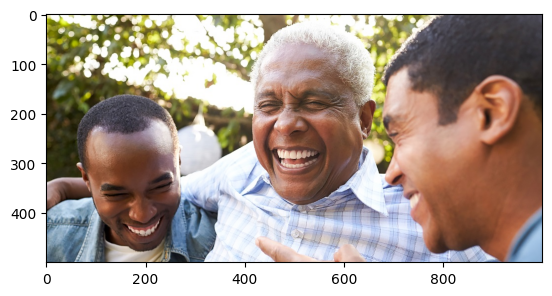

In [666]:
img = cv2.imread('data/happy/who-is-happier.jpg')
# img = cv2.imread('data/sad/secret-signs-of-loneliness-01-1440x810.jpg')
# plt.imshow(img)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

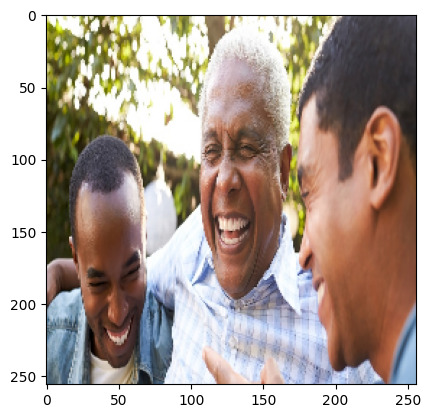

In [667]:
resized_img = cv2.resize(img, (256, 256))
plt.imshow(cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB))
plt.show()

In [668]:
np.expand_dims(resized_img, 0).shape

(1, 256, 256, 3)

In [669]:
prediction = model.predict(np.expand_dims(resized_img/255, 0))

1/1 [==============================] - 0s 13ms/step


In [670]:
print(prediction)
if prediction > 0.5:
    print('Happy')
else:
    print('Sad')

[[0.48133013]]
Sad
